# OKMesoPy Module Usage Examples

OKMesoPy is a tool developed to assist with downloading and manipulating the Oklahoma Mesonet climate dataset. Mesonet provides a rich source of historic climate data and 5 minute sampling variables. The original script was written with the intention of creating timeseries for use with PyHSPF but the Mesonet dataset could be used for any number of climatological, meteorological, or hydrological research.

This notebook provides examples of how to use the module and some explanation of how it works.

In [1]:
# Imports
import os
import urllib.request
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from okmesopy import MesonetDownloader
from okmesopy import MesonetTools
from shapefile import Reader

## MesonetDownloader Class

MesonetDownloader is the class that performs all of the module's downloading and time series generation functions. The MesonetDownloader initialization function has two optional parameters:
- destination: This is the directory where MesonetDownloader will save files downloaded from Mesonet. If no argument is given, it will default to the current directory.
- verbose: This is a boolean argument that determines whether or not verbose logging will be sent to stdout. False by default.

Upon initialization, MesonetDownloader checks for the metadata file in the destination directory and if not found attempts to download it from Mesonet. Because the metadata file is essential for performing all other functions, a FileNotFoundError will he raised if it cannot be loaded.

In [2]:
# set the destination to this notebook's directory
destination = os.getcwd()
downloader = MesonetDownloader(destination, verbose = False)

All of MesonetDownloader's download functions require a start and end date as datetime date objects.

In [3]:
start_date = date(2021, 2, 1)
end_date = date(2021, 2, 10)

## Downloading Data

When MesonetDownloader downloads data, it stores the raw mts files in a folder named mts_files in the destination directory. When using any of the download functions, MesonetDownloader first checks that folder and only downloads files when it cannot find them locally. There are four download functions:
- download_station_data(stid,start_date,end_date)
- download_bounding_box(bbox,start_date,end_date,padding=1)
- download_shape_file(shape_path,start_date,end_date,padding=1,prj_path='')
- download_shape_object(shape,start_date,end_date,padding=1,prj_path='')

**download_station_data(stid,start_date,end_date)** is the most basic download function. It downloads all the data for a single station over the time period from start_date to end_date. The stid argument is case insensitive.

**get_station_ids()** will print a list of all valid station IDs. All station information comes from the metadata which can also be accessed directly using the metadata attribute.

In [4]:
print('Valid site IDs are:')
print(downloader.get_station_ids())

Valid site IDs are:
ADAX ALTU ALV2 ALVA ANT2 ANTL APAC ARD2 ARDM ARNE BBOW BEAV BEEX BESS BIXB BLAC BOIS BOWL BREC BRIS BROK BUFF BURB BURN BUTL BYAR CALV CAMA CARL CATO CENT CHAN CHER CHEY CHIC CLAR CLAY CLOU CLRM COOK COPA DURA ELKC ELRE ERIC EUFA EVAX FAIR FITT FORA FREE FTCB GOOD GRA2 GRAN GUTH HASK HECT HINT HOBA HOLD HOLL HOOK HUGO IDAB INOL JAYX KENT KETC KIN2 KING LAHO LANE MADI MANG MARE MARS MAYR MCAL MEDF MEDI MIAM MINC MRSH MTHE NEWK NEWP NINN NORM NOWA NRMN OILT OKCE OKCN OKCW OKEM OKMU PAUL PAWN PERK PORT PRES PRYO PUTN REDR RETR RING SALL SEIL SEMI SHAW SKIA SLAP SPEN STIG STIL STUA SULP TAHL TALA TALI TIPT TISH TULL TULN VALL VANO VINI WAL2 WALT WASH WATO WAUR WEAT WEB3 WEBB WEBR WEST WILB WIST WOOD WYNO YUKO


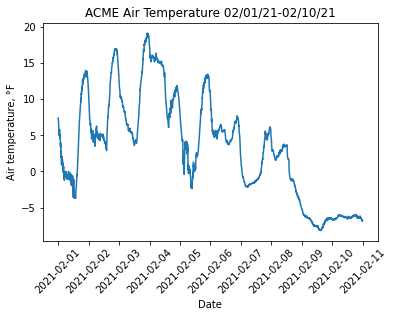

In [5]:
stid = 'acme'
station_data = downloader.download_station_data(stid,start_date,end_date)
plt.plot(station_data['DATETIME'],station_data['TAIR'])
plt.title('{} Air Temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
ticks = plt.xticks(rotation = 45)

**download_bounding_box(bbox,start_date,end_date,padding=1)** will download data for all stations within a specificed bounding box. The bbox argument should be a list in the form [low longitude, low latitude, high longitude, high latitude]. This is the same format that the pyshp library uses. Padding is an optional parameter that will increase or decrease the size of the bounding box. This is discussed further in a later example.

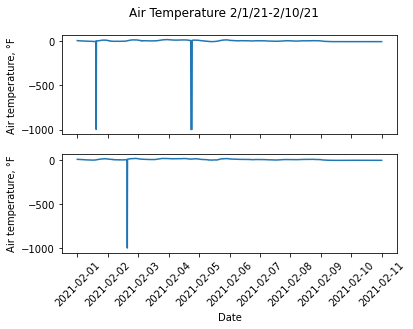

In [6]:
bbox = [-96.5,34,-96,35]
bbox_data = downloader.download_bounding_box(bbox,start_date,end_date)
fig, axs = plt.subplots(2, sharex=True, sharey=True)
fig.suptitle('Air Temperature 2/1/21-2/10/21')
cent_data = bbox_data.loc[bbox_data['STID'] == 'CENT']
stua_data = bbox_data.loc[bbox_data['STID'] == 'STUA']
axs[0].plot(cent_data['DATETIME'],cent_data['TAIR'])
axs[1].plot(stua_data['DATETIME'],stua_data['TAIR'])
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Air temperature, °F')
    ax.label_outer()
ticks = plt.xticks(rotation = 45)

MesonetDownloader provides two methods for working with shapefiles using the pyshp library. Note that both methods simply use the bbox attribute so depending on the shape it may include stations that are outside of the actual shape.

**download_shape_file(shape_path,start_date,end_date,padding=1,prj_path='')** expects a path to a .shp file. This function does not require you to import the pyshp module into your code as reading the shapefile is handled within the MesonetDownloader class.

This first cell will download and unzip the shapefiles that are used in these examples from the Github repository.

In [7]:
# URL where the zipped shapefiles are
git = 'https://github.com/bjrubinstein/okmesopy/blob/main/examples/shapefiles'
# create a directory for the shapefiles
if not os.path.isdir('{}/{}'.format(destination,'shapefiles')): os.mkdir('{}/{}'.format(destination,'shapefiles'))
# names of the two zip files
gl_file = 'grand_lake_watershed.zip'
hc_file = 'horse_creek.zip'
# check if the Grand Lake shape file exists
if not (os.path.exists('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp') and 
        os.path.exists('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.prj')):
    # download the zip file if it doesn't exist already
    if not os.path.exists('{}/shapefiles/{}'.format(destination,gl_file)):
        msg = urllib.request.urlretrieve('{}/{}?raw=true'.format(git,gl_file),'{}/shapefiles/{}'.format(destination,gl_file))
    # extract the shape files from the zip
    with zipfile.ZipFile('{}/shapefiles/{}'.format(destination,gl_file),'r') as zip_ref:
        zip_ref.extractall('{}/shapefiles/'.format(destination))
# check if the Horse Creek shape file exists and download if not
if not os.path.exists('{}/shapefiles/horse_creek/horse_creek.shp'):
    if not os.path.exists('{}/shapefiles/{}'.format(destination,hc_file)):
        msg = urllib.request.urlretrieve('{}/{}?raw=true'.format(git,hc_file),'{}/shapefiles/{}'.format(destination,hc_file))
    with zipfile.ZipFile('{}/shapefiles/{}'.format(destination,hc_file),'r') as zip_ref:
        zip_ref.extractall('{}/shapefiles/'.format(destination))

The Mesonet metadata uses the EPSG:4269 coordinate reference system (CRS). It can generally detect if coordinates are not in latitude-longitude and will give a warning if that is the case.

In [8]:
downloader.verbose = True # turn verbose logging on
shape_data = downloader.download_shape_file('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp'.format(destination),start_date,end_date)

It appears that the bounding box [-123028.0390625, 1478977.375, 213226.515625, 1760277.875] is not in latitude longitude coordinates. Try specifing the prj_path argument when calling this function.


If the optional **prj_path** argument is specified, MesonetDownloader will automatically read the shapefile's CRS and convert it to the correct one.

In [9]:
shape_data = downloader.download_shape_file('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp'.format(destination),start_date,end_date,prj_path='{}/shapefiles/grand_lake_watershed/grand_lake_watershed.prj'.format(destination))
num_stations = len(shape_data['STID'].unique())
stids = ' '.join(shape_data['STID'].unique())
print('Downloaded data for {} stations within the shape file: {}'.format(num_stations,stids))
print(shape_data)

Transforming bounding box from EPSG:5069 to EPSG:4269.
Downloaded data for 15 stations within the shape file: BLAC BURB COPA FORA JAYX MIAM NEWK NOWA PAWN PRYO REDR SKIA TALA VINI WYNO
       STID  STNM  TIME  RELH  TAIR   WSPD   WVEC  WDIR   WDSD   WSSD  ...  \
0      BLAC    11     0    79   2.1    3.3    3.3     2    6.7    0.3  ...   
1      BLAC    11     5    81   1.9    3.6    3.5     3    6.3    0.4  ...   
2      BLAC    11    10    82   1.8    3.8    3.7     2   13.2    0.5  ...   
3      BLAC    11    15    82   1.8    3.8    3.7   360   12.1    0.5  ...   
4      BLAC    11    20    82   1.7    3.7    3.7   355    9.3    0.6  ...   
...     ...   ...   ...   ...   ...    ...    ...   ...    ...    ...  ...   
43195  WYNO   108  1415    86  -8.1 -999.0 -999.0  -999 -999.0 -999.0  ...   
43196  WYNO   108  1420    85  -8.1 -999.0 -999.0  -999 -999.0 -999.0  ...   
43197  WYNO   108  1425    85  -8.2 -999.0 -999.0  -999 -999.0 -999.0  ...   
43198  WYNO   108  1430    85  -8.2

**download_shape_object(shape,start_date,end_date,padding=1,prj_path='')** is the other function for downloading data within a shapefile. It expects a pyshp Reader or Shape object for the shape argument.

As previously mentioned, **padding** is an optional argument that will increase or decrease the size of the bounding box (recall that the shape download functions use the shape's bounding box attribute). If no stations are found and the verbose attribute is true you will get a message suggesting that the padding argument be increased.

In [10]:
shp_path = '{}/shapefiles/horse_creek/horse_creek.shp'.format(destination)
sf = Reader(shp_path)
obj_data = downloader.download_shape_object(sf,start_date,end_date)

No stations found within the bounding box.
[-94.99976083200346, 36.634247035429745, -94.83198491219673, 36.78026945461582]
Try increasing the padding argument.


When the padding argument is specified the length of each side of the bounding box is multiplied by it. The increase in length happens equally in all directions, i.e. the center of the bounding box remains the same.

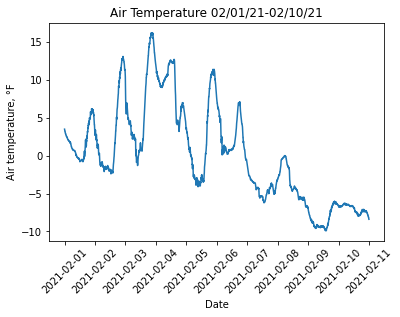

In [11]:
obj_data = downloader.download_shape_object(sf,start_date,end_date,padding=2)
sf.close()
plt.plot(obj_data['DATETIME'],obj_data['TAIR'])
plt.title('Air Temperature {}-{}'.format(start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
ticks = plt.xticks(rotation = 45)